# Saliency and class activation maps
This netowrk illustrates the usage of the visualization tools implemented to show the regions of images that are contributing to specific classifications
## Imports

In [1]:
import sys 
import os
import numpy as np 
import matplotlib.pyplot as plt
import copy
import cv2
import PIL

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
from torch.autograd import Variable

sys.path.insert(0, '../Utils')
from visualize_object_survey import *

## Image pre-processing
In this example we are working with CIFAR-10 dataset, and are following the preprocessing steps that were used while training the classifier (in a seperate macro)

In [3]:
norm_means = (0.4914, 0.4822, 0.4465)
norm_std = (0.247, 0.243, 0.261)
## define series of transforms to pre process images 
transform = torchvision.transforms.Compose([
    #torchvision.transforms.Pad(2),
    torchvision.transforms.CenterCrop(32),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(norm_means, norm_std)
])
trainset = torchvision.datasets.CIFAR10('../Datasets/', train=True, transform=transform,download=True)
train_loader = torch.utils.data.DataLoader(trainset,batch_size = batch_size, shuffle = True)

testset = torchvision.datasets.CIFAR10('../Datasets/', train=False, transform=transform,download=True)
test_loader = torch.utils.data.DataLoader(trainset,batch_size = batch_size, shuffle = False)

SyntaxError: invalid syntax (<ipython-input-3-66eb5c44b7e0>, line 10)

## Image utilities
Some basic funtions to show, save and de-process images for our visualizations

In [4]:
n_classes = 10 #10 plus attack class

def deprocess(image):
    return image * torch.Tensor([0.247, 0.243, 0.261]).cuda()  + torch.Tensor([0.4914, 0.4822, 0.4465]).cuda()

def imshow(img):
    means_inv = tuple(-x/y for x,y in zip(norm_means,norm_std) )
    std_inv = tuple( 1./x for x in norm_std )
    unnorm = torchvision.transforms.Normalize(means_inv, std_inv)
    view_img = unnorm(copy.deepcopy(img))
    view_img = np.array(view_img)
    #img = img / 2 + 0.5
    view_img = np.moveaxis(view_img, 0, -1)
    plt.imshow(view_img)
    
def imsave(img,name):
    img.cpu().detach()
    fig = plt.figure()
    ax1 = fig.add_subplot(1,2,1)
    ax1 = imshow(img)
    fig.savefig(name)

## Example images

32


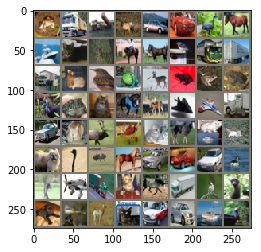

In [5]:
imgs, lbls = iter(test_loader).next()

imshow(torchvision.utils.make_grid(imgs)) 
print(imgs[0].shape[2])

## Classifier
Define the classifier to be used in these examples. We refer back to the tiny_cnn defined in the Utils/models.py file. However, for the case of class activation maps we need access to the output of the last convolutional layer directly, so we redefine the model without use of the nn.Sequential() mode.  

In [6]:
class ns_tiny_cnn(nn.Module): 
    def __init__(self, n_in=3, n_out=10, n_hidden=64, size=64): 
        super(ns_tiny_cnn, self).__init__()
        self.size = size 
        self.n_hidden = n_hidden
        #First block
        self.operation_0 = nn.Conv2d(n_in, n_hidden, kernel_size=5, stride=1, padding=2)
        self.operation_1 = nn.BatchNorm2d(n_hidden) 
        self.operation_2 = nn.ReLU()
        self.operation_3 = nn.MaxPool2d(kernel_size=2, stride=2)
        #Second block
        self.operation_4 = nn.Conv2d(n_hidden, 2*n_hidden, kernel_size=5, stride=1, padding=2) 
        self.operation_5 = nn.BatchNorm2d(2*n_hidden) 
        self.operation_6 = nn.ReLU()
        self.operation_7 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Final FC's
        self.fc = nn.Linear(2*n_hidden * (self.size//4) * (self.size//4), 2*n_hidden)
        self.output = nn.Linear(2*n_hidden, n_out)
        
    def forward(self, x): 
        x = self.operation_0(x)
        x = self.operation_1(x)
        x = self.operation_2(x)
        x = self.operation_3(x)
        x = self.operation_4(x)
        x = self.operation_5(x)
        x = self.operation_7(x)
        x = x.view(x.size(0), -1)
        #x = x.view(-1, 2*self.n_hidden * (self.size//4) * (self.size//4))
        x = self.fc(x)
        out = self.output(x)
        
        return out

## Load the pretrained model

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#define arquitecture
netD = ns_tiny_cnn(n_in=3, n_out=n_classes, n_hidden=32, size=32).to(device)
netD_optim = optim.SGD(netD.parameters(), lr=0.001, momentum=0.9, nesterov=True)
#load trained weights
checkpoint = torch.load('../saved_models/cifar_WhiteBox_attack/ns_tiny_cnn_WB.pth')
netD.load_state_dict(checkpoint['state_dict'])
netD_optim.load_state_dict(checkpoint['optimizer'])


## Basic saliency map

In [9]:
s_map = saliency_map_general(model=netD, input=imgs[0].cuda(), label = 6)

Text(0.5,1,'Saliency Map')

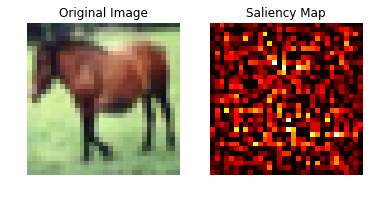

In [10]:
true_image = imgs[7].cuda().data
true_image = true_image.squeeze()
true_image = true_image.transpose(0,1)
true_image = true_image.transpose(1,2)
true_image = deprocess(true_image)

fig = plt.figure()
plt.rcParams["figure.figsize"] = (20, 20)


a = fig.add_subplot(1,2,1)
imgplot = plt.imshow(true_image)
plt.title('Original Image')
plt.axis('off') 

a = fig.add_subplot(1,2,2)
imgplot = plt.imshow(s_map, cmap='hot')
plt.axis('off') 
plt.title('Saliency Map')

## Gradient assisted Class Activation Map (grad-CAM)

In [11]:
grad_cam = gradcam(model = netD,input=imgs[0].cuda(), label  = 6, layer_name='operation_7', plot = False)

(-0.5, 31.5, 31.5, -0.5)

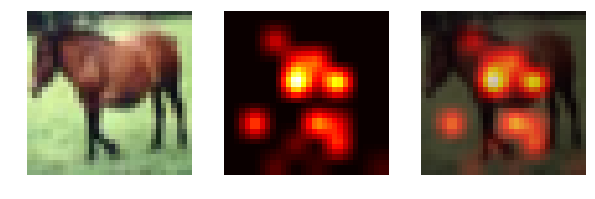

In [12]:
plt.rcParams["figure.figsize"] = (10,10)
plt.subplot(1,3,1)
plt.imshow(true_image)
#plt.imshow(pre_image)
plt.axis('off')
plt.subplot(1,3,2)
plt.axis('off')
plt.imshow(grad_cam, cmap='hot')
plt.subplot(1,3,3)
#
plt.imshow(true_image)
plt.imshow(grad_cam, cmap='hot', alpha=0.7)
plt.axis('off')

## Gradient guided saliency map

In [ ]:
gs_map = guided_saliency_map(model=netD, input=imgs[0].cuda(), label = 6)

Text(0.5,1,'Guided Backprop')

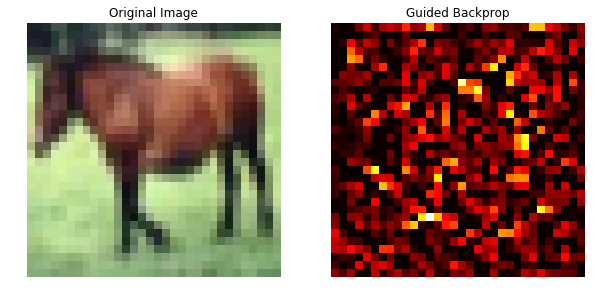

In [14]:
fig = plt.figure()
plt.rcParams["figure.figsize"] = (20, 20)


a = fig.add_subplot(1,2,1)
imgplot = plt.imshow(true_image)
plt.title('Original Image')
plt.axis('off') 

a = fig.add_subplot(1,2,2)
imgplot = plt.imshow(gs_map, cmap='hot')
plt.axis('off') 
plt.title('Guided Backprop')

## Guided grad-CAM
This is a combination of the gradient guided saliency map and grad-CAM

In [15]:
guided_gradcam = guided_gradcam(model=netD,  input=imgs[0].cuda(), layer_name='operation_4', label = 6)

(-0.5, 31.5, 31.5, -0.5)

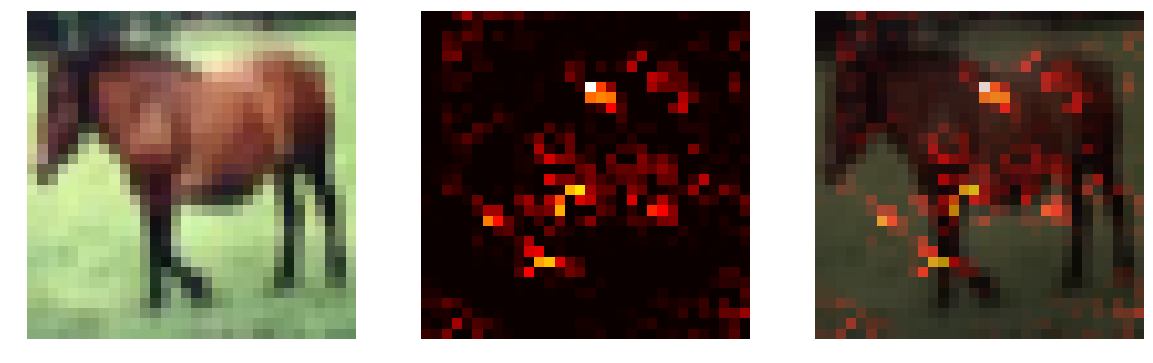

In [16]:
plt.subplot(1,3,1)
plt.imshow(true_image)
plt.axis('off')
plt.subplot(1,3,2)
plt.axis('off')
plt.imshow(guided_gradcam, cmap='hot')
plt.subplot(1,3,3)
plt.imshow(true_image)
plt.imshow(guided_gradcam, cmap='hot', alpha=0.7)
plt.axis('off')

## Smooth gradient guided saliency map
The saliency maps can, at times, be very noisy due to small local variations in the gradients. The smooth gradient guided saliency map accounts for this to produce better a map.

In [17]:
sg_saliency = smooth_guided_saliency_map(model = netD, input=imgs[0].cuda(), label = 6, transform=transform)

Text(0.5,1,'Guided SmoothGrad, Noise: ')

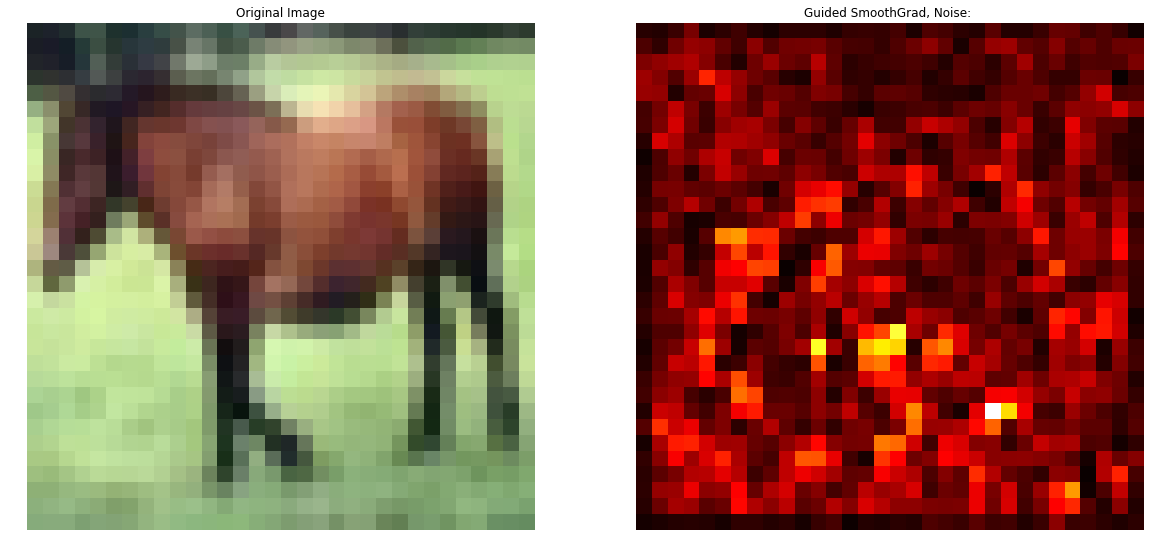

In [18]:
fig = plt.figure()
plt.rcParams["figure.figsize"] = (10, 10)


a = fig.add_subplot(1,2,1)
imgplot = plt.imshow(true_image)
plt.title('Original Image')
plt.axis('off') 

a = fig.add_subplot(1,2,2)
imgplot = plt.imshow(sg_saliency, cmap='hot')
plt.axis('off')  
plt.title('Guided SmoothGrad, Noise: ')

## Smooth guided grad-CAM
This is a combination of the smooth gradient guided saliency map and grad-CAM

In [19]:
sg_gradcam = smooth_guided_gradcam(model=netD,  input=imgs[7].cuda(), transform=transform, layer_name='operation_4', label = 7)

(-0.5, 31.5, 31.5, -0.5)

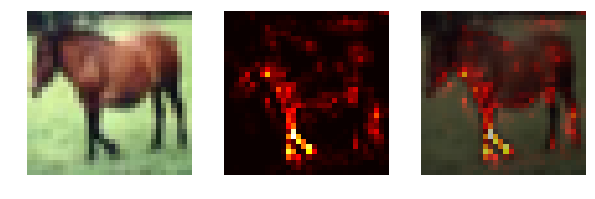

In [20]:
plt.subplot(1,3,1)
plt.imshow(true_image)
plt.axis('off')
plt.subplot(1,3,2)
plt.axis('off')
plt.imshow(sg_gradcam, cmap='hot')
plt.subplot(1,3,3)
plt.imshow(true_image)
plt.imshow(sg_gradcam, cmap='hot', alpha=0.7)
plt.axis('off')


In [21]:
print(imgs[0].shape)
def plot_comparison(img, hmap):
    true_image = img.cuda().data
    true_image = true_image.squeeze()
    true_image = true_image.transpose(0,1)
    true_image = true_image.transpose(1,2)
    true_image = deprocess(true_image)

    plt.subplot(1,3,1)
    plt.imshow(true_image)
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.axis('off')
    plt.imshow(hmap, cmap='hot')
    plt.subplot(1,3,3)
    plt.imshow(true_image)
    plt.imshow(hmap, cmap='hot', alpha=0.7)
    plt.axis('off')

torch.Size([3, 32, 32])
